<a href="https://colab.research.google.com/github/MarianaAmaral-N/Kaggle-Competitions/blob/main/PyCaret_and_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:

import ydf
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from pycaret.datasets import get_data
from pycaret.classification import *




print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.19.0
TensorFlow Decision Forests v1.12.0


In [9]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
#import kagglehub
#kagglehub.login()

from google.colab import files

files.upload()  # upload kaggle.json here
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c spaceship-titanic
!kaggle datasets download -d <dataset-owner>/<dataset-name>
!unzip spaceship-titanic.zip -d spaceship-titanic
import pandas as pd

df = pd.read_csv("spaceship-titanic/train.csv")
df_test = pd.read_csv("spaceship-titanic/test.csv")
print("Antes do pré-processamento:", df_test.shape)


Saving kaggle.json to kaggle.json
spaceship-titanic.zip: Skipping, found more recently modified local copy (use --force to force download)
/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `kaggle datasets download -d <dataset-owner>/<dataset-name>'
Archive:  spaceship-titanic.zip
replace spaceship-titanic/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: spaceship-titanic/sample_submission.csv  
replace spaceship-titanic/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: spaceship-titanic/test.csv  
replace spaceship-titanic/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: spaceship-titanic/train.csv  
Antes do pré-processamento: (4277, 13)


In [10]:

#train_url='/kaggle/input/spaceship-titanic/train.csv'
#test_url='/kaggle/input/spaceship-titanic/test.csv'

#df=pd.read_csv(train_url)
#df_test=pd.read_csv(test_url)

print(df.head())
print(df.describe())
print(df.shape)
print(df.dtypes)
print(df.isnull().count())
print("Antes do pré-processamento:", df_test.shape)


  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True  
  

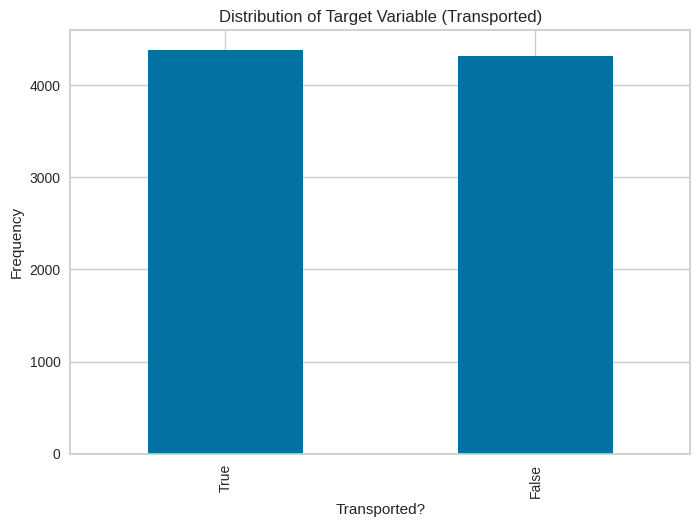

Antes do pré-processamento: (4277, 13)


In [11]:
plot_target=df.Transported.value_counts()
plot_target.plot(kind='bar')
plt.xlabel('Transported?')
plt.ylabel('Frequency')
plt.title('Distribution of Target Variable (Transported)')
plt.show()
print("Antes do pré-processamento:", df_test.shape)


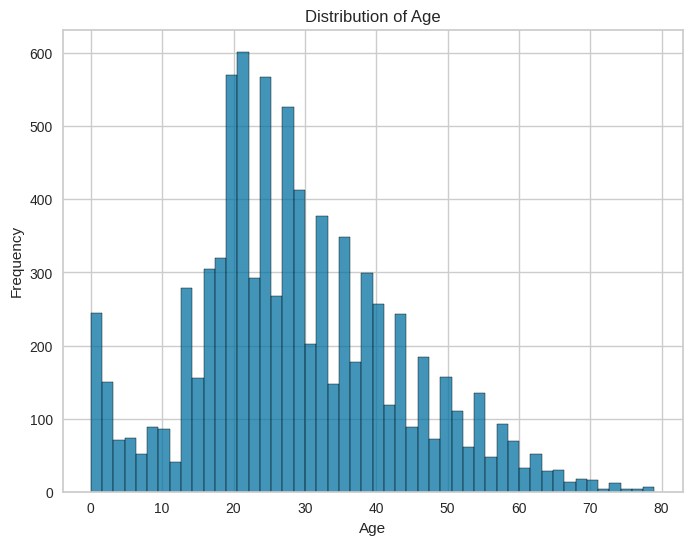

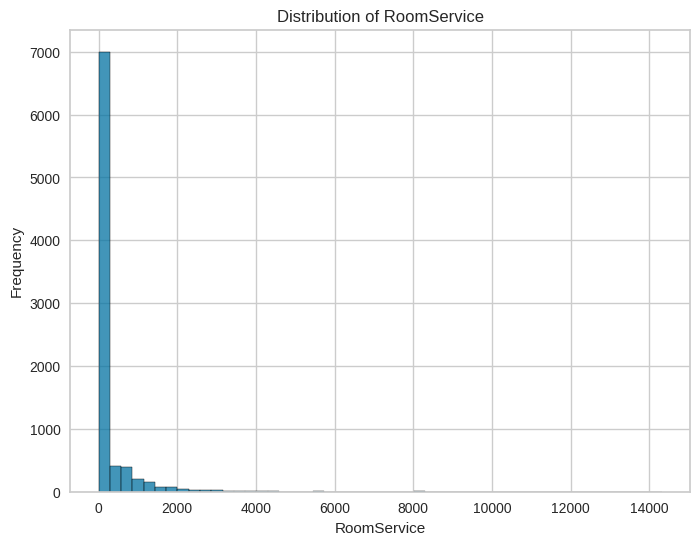

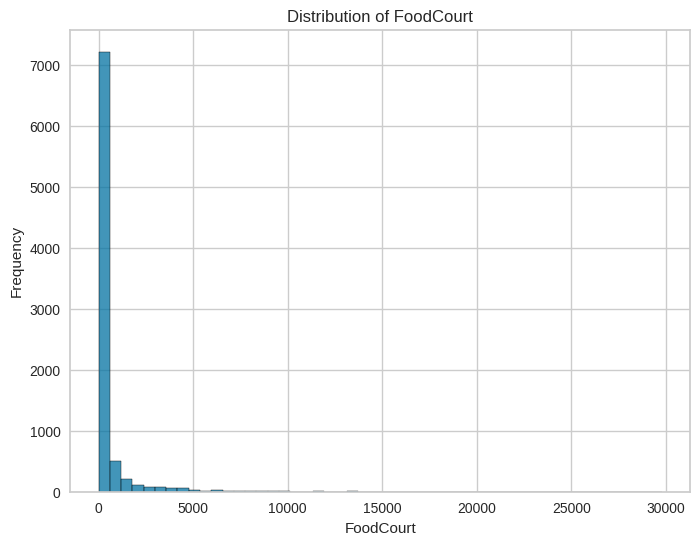

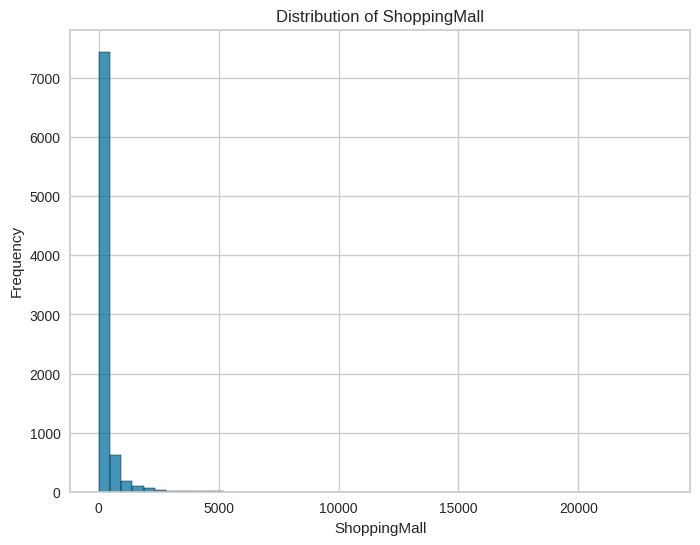

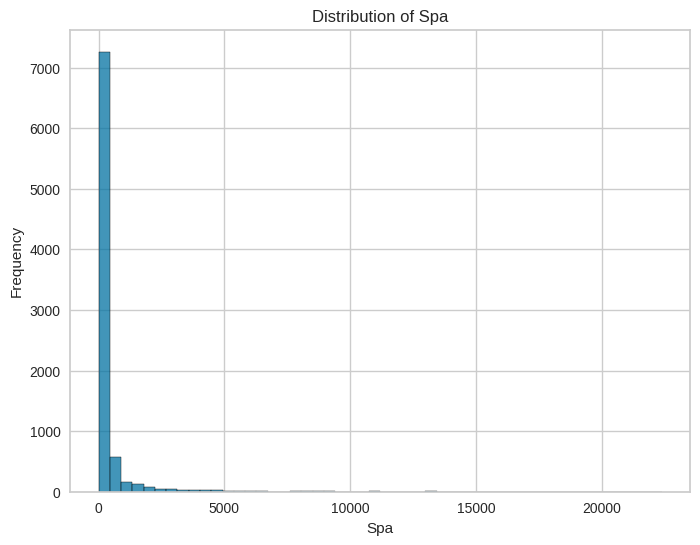

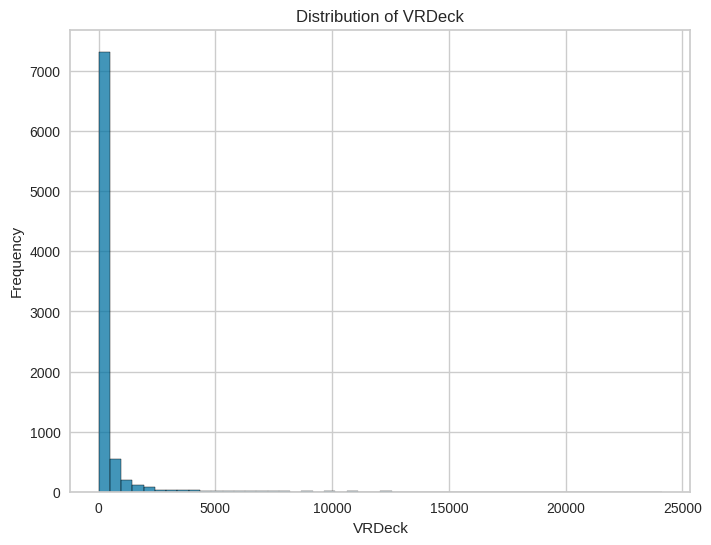

Antes do pré-processamento: (4277, 13)


In [12]:
for col in df.select_dtypes(include=['number']).columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[col], color='b',bins=50)
    plt.title(f"Distribution of {col}")
    plt.xlabel(f"{col}")
    plt.ylabel('Frequency')
    plt.show()
print("Antes do pré-processamento:", df_test.shape)


In [19]:
df1 = df.copy()

# Booleanos → converter para int
df1['VIP'] = df1['VIP'].fillna(False).astype(int)
df1['CryoSleep'] = df1['CryoSleep'].fillna(False).astype(int)

# GroupSize (sem leakage)
df1['GroupID'] = df1['PassengerId'].str.split('_').str[0]
group_sizes = df1['GroupID'].value_counts()
df1['GroupSize'] = df1['GroupID'].map(group_sizes)

# Gastos e interações
df1['TotalSpent'] = df1[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)
df1['TotalSpent_x_VIP'] = df1['TotalSpent'] * df1['VIP']
df1['TotalSpent_per_GroupSize'] = df1['TotalSpent'] / df1['GroupSize']

# Cabin → separar Deck e Side
df1[['Deck','CabinNum','Side']] = df1['Cabin'].str.split('/', expand=True)
df1['Deck'] = df1['Deck'].fillna('Missing').astype('category')
df1['Side'] = df1['Side'].fillna('Missing').astype('category')
df1['Deck_Side'] = (df1['Deck'].astype(str) + '_' + df1['Side'].astype(str)).astype('category')

# Categóricas
categorical_cols = ['Deck','Side','Deck_Side','HomePlanet','Destination']
for col in categorical_cols:
    df1[col] = df1[col].astype('category')
    if 'Missing' not in df1[col].cat.categories:
        df1[col] = df1[col].cat.add_categories('Missing')
    df1[col] = df1[col].fillna('Missing')

# Numéricas
numeric_features = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck',
                   'TotalSpent','TotalSpent_x_VIP','TotalSpent_per_GroupSize',
                   'GroupSize','VIP','CryoSleep','Age']
for col in numeric_features:
    df1[col] = pd.to_numeric(df1[col], errors='coerce')
    df1[col] = df1[col].fillna(df1[col].median())

# 2️⃣ Remover colunas de leakage
df_train = df1.drop(columns=['PassengerId','GroupID','Cabin'])

# Garantir label como booleano
df_train['Transported'] = df_train['Transported'].astype(bool)

# 3️⃣ Treino do modelo YDF
model = ydf.GradientBoostedTreesLearner(label='Transported')

# Treinar
model = model.train(df_train)

# 4️⃣ Avaliação
results = model.evaluate(df_train)
print(results)

Feature Name is a CATEGORICAL feature with an empty dictionary. The feature will not be useful during model training.
Train model on 8693 examples
Model trained in 0:01:10.127590
accuracy: 0.893247
confusion matrix:
    label (row) \ prediction (col)
    +-------+-------+-------+
    |       | false |  true |
    +-------+-------+-------+
    | false |  3820 |   495 |
    +-------+-------+-------+
    |  true |   433 |  3945 |
    +-------+-------+-------+
characteristics:
    name: 'true' vs others
    ROC AUC: 0.959132
    PR AUC: 0.961347
    Num thresholds: 7677
loss: 0.286054
num examples: 8693
num examples (weighted): 8693



In [38]:
df_test1 = df_test.copy()
df_test1['Transported_str'] = 'Missing'

# Booleanos
df_test1['VIP'] = df_test1['VIP'].fillna(False).astype(int)
df_test1['CryoSleep'] = df_test1['CryoSleep'].fillna(False).astype(int)

# GroupID e GroupSize
df_test1['GroupID'] = df_test1['PassengerId'].str.split('_').str[0]
group_sizes_test = df_test1['GroupID'].value_counts()
df_test1['GroupSize'] = df_test1['GroupID'].map(group_sizes_test)

# Gastos totais e interação
df_test1['TotalSpent'] = df_test1[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)
df_test1['TotalSpent_x_VIP'] = df_test1['TotalSpent'] * df_test1['VIP']

# Separar Cabin em Deck / CabinNum / Side, como categoria
if 'Cabin' in df_test1.columns:
    df_test1[['Deck','CabinNum','Side']] = df_test1['Cabin'].str.split('/', expand=True)
    df_test1['CabinNum'] = df_test1['CabinNum'].fillna('Missing').astype(str).astype('category')
    df_test1['Deck'] = df_test1['Deck'].fillna('Missing').astype('category')
    df_test1['Side'] = df_test1['Side'].fillna('Missing').astype('category')
    df_test1['Deck_Side'] = (df_test1['Deck'].astype(str) + '_' + df_test1['Side'].astype(str)).astype('category')
else:
    df_test1['CabinNum'] = 'Missing'
    df_test1['Deck'] = 'Missing'
    df_test1['Side'] = 'Missing'
    df_test1['Deck_Side'] = 'Missing'

# Categóricas restantes
for col in ['HomePlanet','Destination']:
    df_test1[col] = df_test1[col].fillna('Missing').astype('category')

# TotalSpent_per_GroupSize
df_test1['TotalSpent_per_GroupSize'] = df_test1['TotalSpent'] / df_test1['GroupSize']

# Garantir mesmas categorias do treino
df_test1 = df_test.copy()
df_test1['Transported_str'] = 'Missing'

# Booleanos
df_test1['VIP'] = df_test1['VIP'].fillna(False).astype(int)
df_test1['CryoSleep'] = df_test1['CryoSleep'].fillna(False).astype(int)

# GroupID e GroupSize
df_test1['GroupID'] = df_test1['PassengerId'].str.split('_').str[0]
group_sizes_test = df_test1['GroupID'].value_counts()
df_test1['GroupSize'] = df_test1['GroupID'].map(group_sizes_test)

# Gastos totais e interação
df_test1['TotalSpent'] = df_test1[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)
df_test1['TotalSpent_x_VIP'] = df_test1['TotalSpent'] * df_test1['VIP']

# Separar Cabin em Deck / CabinNum / Side, como categoria
if 'Cabin' in df_test1.columns:
    df_test1[['Deck','CabinNum','Side']] = df_test1['Cabin'].str.split('/', expand=True)
    df_test1['CabinNum'] = df_test1['CabinNum'].fillna('Missing').astype(str).astype('category')
    df_test1['Deck'] = df_test1['Deck'].fillna('Missing').astype('category')
    df_test1['Side'] = df_test1['Side'].fillna('Missing').astype('category')
    df_test1['Deck_Side'] = (df_test1['Deck'].astype(str) + '_' + df_test1['Side'].astype(str)).astype('category')
else:
    df_test1['CabinNum'] = 'Missing'
    df_test1['Deck'] = 'Missing'
    df_test1['Side'] = 'Missing'
    df_test1['Deck_Side'] = 'Missing'

# Categóricas restantes
cat_cols = ['Deck','Side','Deck_Side','HomePlanet','Destination','CabinNum']

for col in cat_cols:
    # garantir que é categoria
    df_test1[col] = df_test1[col].astype('category')
    if col in df_train.columns and pd.api.types.is_categorical_dtype(df_train[col]):
        # usar as mesmas categorias do treino
        df_test1[col] = df_test1[col].cat.set_categories(df_train[col].cat.categories)
    df_test1[col] = df_test1[col].fillna('Missing')

# TotalSpent_per_GroupSize
df_test1['TotalSpent_per_GroupSize'] = df_test1['TotalSpent'] / df_test1['GroupSize']

cat_cols = ['Deck','Side','Deck_Side','HomePlanet','Destination','CabinNum']

for col in cat_cols:
    # garantir que existe no df_test1
    if col in df_test1.columns:
        # converter para category
        df_test1[col] = df_test1[col].astype('category')

        # se a coluna existir no df_train e for categórica, alinhar categorias
        if col in df_train.columns and pd.api.types.is_categorical_dtype(df_train[col]):
            df_test1[col] = df_test1[col].cat.set_categories(df_train[col].cat.categories)

        # preencher NAs
        df_test1[col] = df_test1[col].fillna('Missing')
# Garantir mesma ordem de colunas do treino (tirando a target)
df_test1_model = df_test1[df_train.columns.drop('Transported')]

# Previsão
y_pred = model.predict(df_test1_model)


# Garantir mesma ordem de colunas do treino (tirando a target)
df_test1_model = df_test1[df_train.columns.drop('Transported')]

# Previsão
y_pred = model.predict(df_test1_model)

df_test1 = df_test.copy()
df_test1['Transported_str'] = 'Missing'

# Booleanos
df_test1['VIP'] = df_test1['VIP'].fillna(False).astype(int)
df_test1['CryoSleep'] = df_test1['CryoSleep'].fillna(False).astype(int)

# GroupID e GroupSize
df_test1['GroupID'] = df_test1['PassengerId'].str.split('_').str[0]
group_sizes_test = df_test1['GroupID'].value_counts()
df_test1['GroupSize'] = df_test1['GroupID'].map(group_sizes_test)

# Gastos totais e interação
df_test1['TotalSpent'] = df_test1[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)
df_test1['TotalSpent_x_VIP'] = df_test1['TotalSpent'] * df_test1['VIP']

# Separar Cabin em Deck / CabinNum / Side, como categoria
if 'Cabin' in df_test1.columns:
    df_test1[['Deck','CabinNum','Side']] = df_test1['Cabin'].str.split('/', expand=True)
    df_test1['CabinNum'] = df_test1['CabinNum'].fillna('Missing').astype(str).astype('category')
    df_test1['Deck'] = df_test1['Deck'].fillna('Missing').astype('category')
    df_test1['Side'] = df_test1['Side'].fillna('Missing').astype('category')
    df_test1['Deck_Side'] = (df_test1['Deck'].astype(str) + '_' + df_test1['Side'].astype(str)).astype('category')
else:
    df_test1['CabinNum'] = 'Missing'
    df_test1['Deck'] = 'Missing'
    df_test1['Side'] = 'Missing'
    df_test1['Deck_Side'] = 'Missing'

# Categóricas restantes
for col in ['HomePlanet','Destination']:
    df_test1[col] = df_test1[col].fillna('Missing').astype('category')

# TotalSpent_per_GroupSize
df_test1['TotalSpent_per_GroupSize'] = df_test1['TotalSpent'] / df_test1['GroupSize']

# Garantir mesmas categorias do treino
df_test1 = df_test.copy()
df_test1['Transported_str'] = 'Missing'

# Booleanos
df_test1['VIP'] = df_test1['VIP'].fillna(False).astype(int)
df_test1['CryoSleep'] = df_test1['CryoSleep'].fillna(False).astype(int)

# GroupID e GroupSize
df_test1['GroupID'] = df_test1['PassengerId'].str.split('_').str[0]
group_sizes_test = df_test1['GroupID'].value_counts()
df_test1['GroupSize'] = df_test1['GroupID'].map(group_sizes_test)

# Gastos totais e interação
df_test1['TotalSpent'] = df_test1[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)
df_test1['TotalSpent_x_VIP'] = df_test1['TotalSpent'] * df_test1['VIP']

# Separar Cabin em Deck / CabinNum / Side, como categoria
if 'Cabin' in df_test1.columns:
    df_test1[['Deck','CabinNum','Side']] = df_test1['Cabin'].str.split('/', expand=True)
    df_test1['CabinNum'] = df_test1['CabinNum'].fillna('Missing').astype(str).astype('category')
    df_test1['Deck'] = df_test1['Deck'].fillna('Missing').astype('category')
    df_test1['Side'] = df_test1['Side'].fillna('Missing').astype('category')
    df_test1['Deck_Side'] = (df_test1['Deck'].astype(str) + '_' + df_test1['Side'].astype(str)).astype('category')
else:
    df_test1['CabinNum'] = 'Missing'
    df_test1['Deck'] = 'Missing'
    df_test1['Side'] = 'Missing'
    df_test1['Deck_Side'] = 'Missing'

# Categóricas restantes
cat_cols = ['Deck','Side','Deck_Side','HomePlanet','Destination','CabinNum']

for col in cat_cols:
    # garantir que é categoria
    df_test1[col] = df_test1[col].astype('category')
    if col in df_train.columns and pd.api.types.is_categorical_dtype(df_train[col]):
        # usar as mesmas categorias do treino
        df_test1[col] = df_test1[col].cat.set_categories(df_train[col].cat.categories)
    df_test1[col] = df_test1[col].fillna('Missing')

# TotalSpent_per_GroupSize
df_test1['TotalSpent_per_GroupSize'] = df_test1['TotalSpent'] / df_test1['GroupSize']

cat_cols = ['Deck','Side','Deck_Side','HomePlanet','Destination','CabinNum']

for col in cat_cols:
    # garantir que existe no df_test1
    if col in df_test1.columns:
        # converter para category
        df_test1[col] = df_test1[col].astype('category')

        # se a coluna existir no df_train e for categórica, alinhar categorias
        if col in df_train.columns and pd.api.types.is_categorical_dtype(df_train[col]):
            df_test1[col] = df_test1[col].cat.set_categories(df_train[col].cat.categories)

        # preencher NAs
        df_test1[col] = df_test1[col].fillna('Missing')
# Garantir mesma ordem de colunas do treino (tirando a target)
df_test1_model = df_test1[df_train.columns.drop('Transported')]

# Previsão
y_pred = model.predict(df_test1_model)
df_test1 = df_test.copy()
df_test1['Transported_str'] = 'Missing'

# Booleanos
df_test1['VIP'] = df_test1['VIP'].fillna(False).astype(int)
df_test1['CryoSleep'] = df_test1['CryoSleep'].fillna(False).astype(int)

# GroupID e GroupSize
df_test1['GroupID'] = df_test1['PassengerId'].str.split('_').str[0]
group_sizes_test = df_test1['GroupID'].value_counts()
df_test1['GroupSize'] = df_test1['GroupID'].map(group_sizes_test)

# Gastos totais e interação
df_test1['TotalSpent'] = df_test1[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)
df_test1['TotalSpent_x_VIP'] = df_test1['TotalSpent'] * df_test1['VIP']

# Separar Cabin em Deck / CabinNum / Side, como categoria
if 'Cabin' in df_test1.columns:
    df_test1[['Deck','CabinNum','Side']] = df_test1['Cabin'].str.split('/', expand=True)
    df_test1['CabinNum'] = df_test1['CabinNum'].fillna('Missing').astype(str).astype('category')
    df_test1['Deck'] = df_test1['Deck'].fillna('Missing').astype('category')
    df_test1['Side'] = df_test1['Side'].fillna('Missing').astype('category')
    df_test1['Deck_Side'] = (df_test1['Deck'].astype(str) + '_' + df_test1['Side'].astype(str)).astype('category')
else:
    df_test1['CabinNum'] = 'Missing'
    df_test1['Deck'] = 'Missing'
    df_test1['Side'] = 'Missing'
    df_test1['Deck_Side'] = 'Missing'

# Categóricas restantes
for col in ['HomePlanet','Destination']:
    df_test1[col] = df_test1[col].fillna('Missing').astype('category')

# TotalSpent_per_GroupSize
df_test1['TotalSpent_per_GroupSize'] = df_test1['TotalSpent'] / df_test1['GroupSize']

# Garantir mesmas categorias do treino
df_test1 = df_test.copy()
df_test1['Transported_str'] = 'Missing'

# Booleanos
df_test1['VIP'] = df_test1['VIP'].fillna(False).astype(int)
df_test1['CryoSleep'] = df_test1['CryoSleep'].fillna(False).astype(int)

# GroupID e GroupSize
df_test1['GroupID'] = df_test1['PassengerId'].str.split('_').str[0]
group_sizes_test = df_test1['GroupID'].value_counts()
df_test1['GroupSize'] = df_test1['GroupID'].map(group_sizes_test)

# Gastos totais e interação
df_test1['TotalSpent'] = df_test1[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)
df_test1['TotalSpent_x_VIP'] = df_test1['TotalSpent'] * df_test1['VIP']

# Separar Cabin em Deck / CabinNum / Side, como categoria
if 'Cabin' in df_test1.columns:
    df_test1[['Deck','CabinNum','Side']] = df_test1['Cabin'].str.split('/', expand=True)
    df_test1['CabinNum'] = df_test1['CabinNum'].fillna('Missing').astype(str).astype('category')
    df_test1['Deck'] = df_test1['Deck'].fillna('Missing').astype('category')
    df_test1['Side'] = df_test1['Side'].fillna('Missing').astype('category')
    df_test1['Deck_Side'] = (df_test1['Deck'].astype(str) + '_' + df_test1['Side'].astype(str)).astype('category')
else:
    df_test1['CabinNum'] = 'Missing'
    df_test1['Deck'] = 'Missing'
    df_test1['Side'] = 'Missing'
    df_test1['Deck_Side'] = 'Missing'

# Categóricas restantes
cat_cols = ['Deck','Side','Deck_Side','HomePlanet','Destination','CabinNum']

for col in cat_cols:
    # garantir que é categoria
    df_test1[col] = df_test1[col].astype('category')
    if col in df_train.columns and pd.api.types.is_categorical_dtype(df_train[col]):
        # usar as mesmas categorias do treino
        df_test1[col] = df_test1[col].cat.set_categories(df_train[col].cat.categories)
    df_test1[col] = df_test1[col].fillna('Missing')

# TotalSpent_per_GroupSize
df_test1['TotalSpent_per_GroupSize'] = df_test1['TotalSpent'] / df_test1['GroupSize']

cat_cols = ['Deck','Side','Deck_Side','HomePlanet','Destination','CabinNum']

for col in cat_cols:
    # garantir que existe no df_test1
    if col in df_test1.columns:
        # converter para category
        df_test1[col] = df_test1[col].astype('category')

        # se a coluna existir no df_train e for categórica, alinhar categorias
        if col in df_train.columns and pd.api.types.is_categorical_dtype(df_train[col]):
            df_test1[col] = df_test1[col].cat.set_categories(df_train[col].cat.categories)

        # preencher NAs
        df_test1[col] = df_test1[col].fillna('Missing')
# Garantir mesma ordem de colunas do treino (tirando a target)
df_test1_model = df_test1[df_train.columns.drop('Transported')]

# Previsão
y_pred = model.predict(df_test1_model)


df_test1 = df_test.copy()
df_test1['Transported_str'] = 'Missing'

# Booleanos
df_test1['VIP'] = df_test1['VIP'].fillna(False).astype(int)
df_test1['CryoSleep'] = df_test1['CryoSleep'].fillna(False).astype(int)

# GroupID e GroupSize
df_test1['GroupID'] = df_test1['PassengerId'].str.split('_').str[0]
group_sizes_test = df_test1['GroupID'].value_counts()
df_test1['GroupSize'] = df_test1['GroupID'].map(group_sizes_test)

# Gastos totais e interação
df_test1['TotalSpent'] = df_test1[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)
df_test1['TotalSpent_x_VIP'] = df_test1['TotalSpent'] * df_test1['VIP']

# Separar Cabin em Deck / CabinNum / Side, como categoria
if 'Cabin' in df_test1.columns:
    df_test1[['Deck','CabinNum','Side']] = df_test1['Cabin'].str.split('/', expand=True)
    df_test1['CabinNum'] = df_test1['CabinNum'].fillna('Missing').astype(str).astype('category')
    df_test1['Deck'] = df_test1['Deck'].fillna('Missing').astype('category')
    df_test1['Side'] = df_test1['Side'].fillna('Missing').astype('category')
    df_test1['Deck_Side'] = (df_test1['Deck'].astype(str) + '_' + df_test1['Side'].astype(str)).astype('category')
else:
    df_test1['CabinNum'] = 'Missing'
    df_test1['Deck'] = 'Missing'
    df_test1['Side'] = 'Missing'
    df_test1['Deck_Side'] = 'Missing'

# Categóricas restantes
for col in ['HomePlanet','Destination']:
    df_test1[col] = df_test1[col].fillna('Missing').astype('category')

# TotalSpent_per_GroupSize
df_test1['TotalSpent_per_GroupSize'] = df_test1['TotalSpent'] / df_test1['GroupSize']

# Garantir mesmas categorias do treino
df_test1 = df_test.copy()
df_test1['Transported_str'] = 'Missing'

# Booleanos
df_test1['VIP'] = df_test1['VIP'].fillna(False).astype(int)
df_test1['CryoSleep'] = df_test1['CryoSleep'].fillna(False).astype(int)

# GroupID e GroupSize
df_test1['GroupID'] = df_test1['PassengerId'].str.split('_').str[0]
group_sizes_test = df_test1['GroupID'].value_counts()
df_test1['GroupSize'] = df_test1['GroupID'].map(group_sizes_test)

# Gastos totais e interação
df_test1['TotalSpent'] = df_test1[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)
df_test1['TotalSpent_x_VIP'] = df_test1['TotalSpent'] * df_test1['VIP']

# Separar Cabin em Deck / CabinNum / Side, como categoria
if 'Cabin' in df_test1.columns:
    df_test1[['Deck','CabinNum','Side']] = df_test1['Cabin'].str.split('/', expand=True)
    df_test1['CabinNum'] = df_test1['CabinNum'].fillna('Missing').astype(str).astype('category')
    df_test1['Deck'] = df_test1['Deck'].fillna('Missing').astype('category')
    df_test1['Side'] = df_test1['Side'].fillna('Missing').astype('category')
    df_test1['Deck_Side'] = (df_test1['Deck'].astype(str) + '_' + df_test1['Side'].astype(str)).astype('category')
else:
    df_test1['CabinNum'] = 'Missing'
    df_test1['Deck'] = 'Missing'
    df_test1['Side'] = 'Missing'
    df_test1['Deck_Side'] = 'Missing'

# Categóricas restantes
cat_cols = ['Deck','Side','Deck_Side','HomePlanet','Destination','CabinNum']

for col in cat_cols:
    # garantir que é categoria
    df_test1[col] = df_test1[col].astype('category')
    if col in df_train.columns and pd.api.types.is_categorical_dtype(df_train[col]):
        # usar as mesmas categorias do treino
        df_test1[col] = df_test1[col].cat.set_categories(df_train[col].cat.categories)
    df_test1[col] = df_test1[col].fillna('Missing')

# TotalSpent_per_GroupSize
df_test1['TotalSpent_per_GroupSize'] = df_test1['TotalSpent'] / df_test1['GroupSize']

cat_cols = ['Deck','Side','Deck_Side','HomePlanet','Destination','CabinNum']

for col in cat_cols:
    # garantir que existe no df_test1
    if col in df_test1.columns:
        # converter para category
        df_test1[col] = df_test1[col].astype('category')

        # se a coluna existir no df_train e for categórica, alinhar categorias
        if col in df_train.columns and pd.api.types.is_categorical_dtype(df_train[col]):
            df_test1[col] = df_test1[col].cat.set_categories(df_train[col].cat.categories)

        # preencher NAs
        df_test1[col] = df_test1[col].fillna('Missing')
# Garantir mesma ordem de colunas do treino (tirando a target)
df_test1_model = df_test1[df_train.columns.drop('Transported')]

# Previsão
y_pred = model.predict(df_test1_model)

if y_pred.dtype.kind in 'fc':  # float ou complex
    y_pred = y_pred >= 0.5

submission_df = pd.DataFrame({
    "PassengerId": df_test["PassengerId"].values,
    "Transported": y_pred
})

print(submission_df.head(20))

submission_df.to_csv('submission_MA.csv', index=False)
files.download('submission_MA.csv')




   PassengerId  Transported
0      0013_01         True
1      0018_01        False
2      0019_01         True
3      0021_01         True
4      0023_01         True
5      0027_01        False
6      0029_01         True
7      0032_01         True
8      0032_02         True
9      0033_01        False
10     0037_01        False
11     0040_01        False
12     0040_02         True
13     0042_01        False
14     0046_01        False
15     0046_02        False
16     0046_03        False
17     0047_01         True
18     0047_02         True
19     0047_03        False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

randf = tfdf.keras.RandomForestModel(
    num_trees=200,
    max_depth=10,
    min_examples=5
)

randf.compile(metrics=["accuracy"])

In [ ]:
#prepare submission file

#submission_MA=pd.DataFrame({'PassengerId':submission_ID,
                           #'Transported': n_predictions.squeeze()})
#submission_MA.to_csv('submission_MA.csv', index=False)
#print('File successfully created')
#print(submission_MA.head(20))

#files.download('submission_MA.csv')